In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from joblib import dump, load

# Load data

In [2]:
path = r"C:\Users\matta\Desktop\Documents\Python\Geolocation\climate_data\working_data\clean_labeled_climate_data.pkl"
df = pd.read_pickle(path)
df.shape

(470342, 125)

In [3]:
labels = pd.DataFrame(df[['Level_1', 'Level_2', 'Level_3', 'Level_4', 'ECO_NAME', 'climates_f']])
df = df.drop(columns = ['Level_1', 'Level_2', 'Level_3', 'Level_4', 'ECO_NAME', 'climates_f'])

# Train test split

In [4]:
X = df[['longitude', 'latitude', 'jan_tmin', 'annual_tmin', 'annual_meant', 'jul_maxt', 'annual_maxt']]

y = df[['jan_dptmean', 'jul_dptmean', 'annual_dptmean',
        'jan_precip', 'feb_precip', 'mar_precip', 'apr_precip', 'may_precip', 'jun_precip', 
        'jul_precip', 'aug_precip', 'sep_precip', 'oct_precip', 'nov_precip', 'dec_precip', 'annual_precip']] 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.4)

# Modeling

## Random forest

Random forest took a very long time so is not used here

In [6]:
#rfr = MultiOutputRegressor(RandomForestRegressor())

#rfr.fit(X_train, Y_train)

In [7]:
#Y_pred = rfr.predict(X_test)
#Y_pred = pd.DataFrame(Y_pred, columns=y.columns)

In [8]:
#metrics = {}

#for col in y.columns:
#    rmse = np.sqrt(mean_squared_error(Y_test[col], Y_pred[col]))
#    r2 = r2_score(Y_test[col], Y_pred[col])
#    metrics[col] = {'RMSE': rmse, 'R²': r2}

#metrics_df = pd.DataFrame(metrics).T
#print(metrics_df)

## XGBoost

[I 2025-10-22 18:25:54,462] A new study created in memory with name: xgboost_multioutput_tuning


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-22 18:27:10,958] Trial 0 finished with value: -0.9768472798168659 and parameters: {'n_estimators': 411, 'learning_rate': 0.1258721411792036, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.7413780778400099, 'colsample_bytree': 0.984170691228855, 'gamma': 0.013609794727336255, 'reg_lambda': 0.5007075925112308, 'reg_alpha': 0.635347127896343}. Best is trial 0 with value: -0.9768472798168659.
[I 2025-10-22 18:29:32,345] Trial 1 finished with value: -0.981150422245264 and parameters: {'n_estimators': 300, 'learning_rate': 0.017681847885107797, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8739454357182704, 'colsample_bytree': 0.6477923949799133, 'gamma': 0.9574374655090061, 'reg_lambda': 1.0204786816577425, 'reg_alpha': 0.24554833546629673}. Best is trial 1 with value: -0.981150422245264.
[I 2025-10-22 18:31:54,793] Trial 2 finished with value: -0.9902865551412106 and parameters: {'n_estimators': 312, 'learning_rate': 0.05011885656386479, 'max_depth': 10, 'min_chil

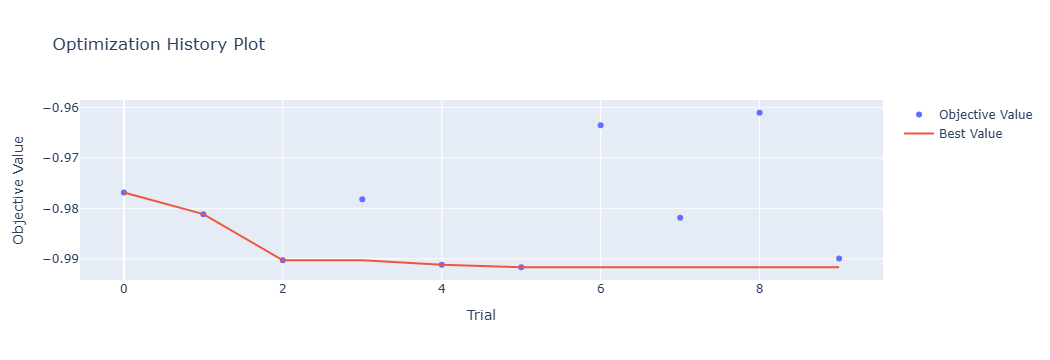

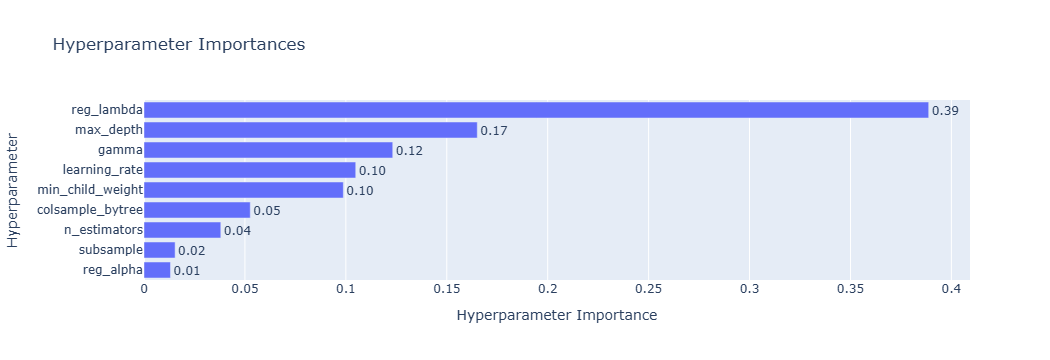

In [9]:
# Objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 3.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'tree_method': 'hist',
        'n_jobs': -1,
        'random_state': 42
    }

    model = MultiOutputRegressor(XGBRegressor(**params))
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    r2_scores = [r2_score(Y_test.iloc[:, i], Y_pred[:, i]) for i in range(Y_test.shape[1])]
    mean_r2 = np.mean(r2_scores)
    return -mean_r2  # negate to make Optuna minimize the negative R²

# Run the Optuna study
study = optuna.create_study(direction='minimize', study_name='xgboost_multioutput_tuning')
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Results
print("\n✅ Best trial:")
print(f"Value (negative R²): {study.best_trial.value}")
print(f"Best R²: {-study.best_trial.value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

try:
    optuna.visualization.plot_optimization_history(study).show()
    optuna.visualization.plot_param_importances(study).show()
except Exception as e:
    print(f"Visualization skipped ({e})")

In [10]:
# Retrain the best model
best_params = study.best_params
best_model = MultiOutputRegressor(XGBRegressor(**best_params))
best_model.fit(X_train, Y_train)

Y_pred = best_model.predict(X_test)

# Compute final per-variable metrics
metrics = {}
for col, pred in zip(Y_test.columns, Y_pred.T):
    metrics[col] = {
        'RMSE': np.sqrt(np.mean((Y_test[col] - pred) ** 2)),
        'R²': r2_score(Y_test[col], pred)
    }

metrics_df = pd.DataFrame(metrics).T
print("\n📊 Per-variable performance:")
print(metrics_df)
print("\nMean R²:", metrics_df["R²"].mean())


📊 Per-variable performance:
                     RMSE        R²
jan_dptmean      0.203249  0.998781
jul_dptmean      0.231256  0.998772
annual_dptmean   0.191299  0.998899
jan_precip       7.639071  0.984269
feb_precip       5.868390  0.985666
mar_precip       6.040705  0.985563
apr_precip       4.416145  0.989062
may_precip       3.228141  0.993477
jun_precip       2.654852  0.996743
jul_precip       2.234065  0.997519
aug_precip       2.180416  0.997389
sep_precip       2.492443  0.995875
oct_precip       4.400437  0.986978
nov_precip       6.767270  0.984901
dec_precip       7.883432  0.985043
annual_precip   47.468712  0.989461

Mean R²: 0.9917749017477036


# Saving model

In [13]:
# Save model
dump(best_model, r"C:\Users\matta\Desktop\Documents\Python\Geolocation\climate_data\working_data\best_xgb_multioutput_model.joblib")

print("✅ Model saved successfully!")

✅ Model saved successfully!
